In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [27]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from PIL import Image
import os
import random
from itertools import combinations
import matplotlib.image as mpimg

# Import Data

In [3]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions_train_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [4]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [6]:
transactions_train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


I want to use articles_df to give product recommendation based on similarity between the articles

In [7]:
print(f"Number of rows in articles is {articles_df.shape[0]}")
print(f"Number of columns in articles is {articles_df.shape[1]}")
print("\nInformation of articles:")
articles_df.info()

Number of rows in articles is 105542
Number of columns in articles is 25

Information of articles:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_v

In [8]:
for i in articles_df.columns:
    print(f"{i} has {articles_df[i].nunique()} columns")

article_id has 105542 columns
product_code has 47224 columns
prod_name has 45875 columns
product_type_no has 132 columns
product_type_name has 131 columns
product_group_name has 19 columns
graphical_appearance_no has 30 columns
graphical_appearance_name has 30 columns
colour_group_code has 50 columns
colour_group_name has 50 columns
perceived_colour_value_id has 8 columns
perceived_colour_value_name has 8 columns
perceived_colour_master_id has 20 columns
perceived_colour_master_name has 20 columns
department_no has 299 columns
department_name has 250 columns
index_code has 10 columns
index_name has 10 columns
index_group_no has 5 columns
index_group_name has 5 columns
section_no has 57 columns
section_name has 56 columns
garment_group_no has 21 columns
garment_group_name has 21 columns
detail_desc has 43404 columns


I want to drop columns that represent the same thing. So I will drop
* product_type_no
* graphical_appearance_no
* colour_group_code
* perceived_colour_value_id 
* perceived_colour_master_id
* index_code
* index_group_no
* section_no
* garment_group_no

Among remaining columns I only want to use below columns as my features that has maximum information
Not considering prod_name (It has 45875 columns which is too much of information to handle with our memory)
* product_type_name
* graphical_appearance_name
* colour_group_name
* department_name  

In [9]:
features_columns = ["product_type_name", "graphical_appearance_name", "colour_group_name", "department_name"]

In [10]:
features_df = articles_df[["article_id","product_type_name", "graphical_appearance_name", "colour_group_name", "department_name"]]
features_encoded_df = pd.get_dummies(features_df, columns = features_columns, drop_first = False)


In [11]:
features_encoded_df.shape

(105542, 462)

In [12]:
item_vector = features_encoded_df.set_index("article_id")
item_vector

,product_type_name_Accessories set,product_type_name_Alice band,product_type_name_Baby Bib,product_type_name_Backpack,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Beanie,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blanket,...,department_name_Young Girl Jersey Basic,department_name_Young Girl Jersey Fancy,department_name_Young Girl Knitwear,department_name_Young Girl Outdoor,department_name_Young Girl S&T,department_name_Young Girl Shoes,department_name_Young Girl Swimwear,department_name_Young Girl Trouser,department_name_Young Girl UW/NW,department_name_Young boy Swimwear
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108775044,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108775051,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
110065001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
110065002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
953763001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
956217002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
#we are convertinbg our dataframe to tensor flow tensor to deal with memeory error issue
item_tensor = tf.convert_to_tensor(item_vector, dtype = tf.float32)

I0000 00:00:1730244527.789510      13 service.cc:145] XLA service 0x57c77e8d2520 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730244527.789567      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1730244527.789572      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1730244527.789575      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1730244527.789578      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1730244527.789581      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1730244527.789584      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1730244527.789587      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1730244527.789589      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [14]:
normalized_item_tensor = tf.nn.l2_normalize(item_tensor, axis=1)
normalized_item_tensor

<tf.Tensor: shape=(105542, 461), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [15]:
#compute cosine similairty_matrix
cosine_similarity_matrix = tf.matmul(normalized_item_tensor, normalized_item_tensor, transpose_b = True)

In [16]:
cosine_similarity_matrix 

<tf.Tensor: shape=(105542, 105542), dtype=float32, numpy=
array([[0.99999976, 0.7499998 , 0.49999988, ..., 0.49999994, 0.49999994,
        0.24999997],
       [0.7499998 , 0.99999976, 0.49999988, ..., 0.24999997, 0.24999997,
        0.24999997],
       [0.49999988, 0.49999988, 0.99999976, ..., 0.        , 0.        ,
        0.24999997],
       ...,
       [0.49999994, 0.24999997, 0.        , ..., 1.        , 0.5       ,
        0.75      ],
       [0.49999994, 0.24999997, 0.        , ..., 0.5       , 1.        ,
        0.25      ],
       [0.24999997, 0.24999997, 0.24999997, ..., 0.75      , 0.25      ,
        1.        ]], dtype=float32)>

In [17]:
similarity_df = pd.DataFrame(cosine_similarity_matrix, index = item_vector.index, columns = item_vector.index)
similarity_df

article_id,108775015,108775044,108775051,110065001,110065002,110065011,111565001,111565003,111586001,111593001,...,949594001,950449002,952267001,952937003,952938001,953450001,953763001,956217002,957375001,959461001
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,1.00,0.75,0.50,0.50,0.25,0.25,0.50,0.25,0.50,0.50,...,0.25,0.25,0.25,0.00,0.00,0.25,0.75,0.50,0.50,0.25
108775044,0.75,1.00,0.50,0.25,0.50,0.25,0.25,0.25,0.25,0.25,...,0.25,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.25,0.25
108775051,0.50,0.50,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.25
110065001,0.50,0.25,0.00,1.00,0.75,0.75,0.50,0.25,0.50,0.50,...,0.25,0.25,0.25,0.00,0.00,0.25,0.50,0.50,0.50,0.25
110065002,0.25,0.50,0.00,0.75,1.00,0.75,0.25,0.25,0.25,0.25,...,0.25,0.25,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,0.25,0.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.25,...,0.00,0.00,0.25,0.00,0.00,1.00,0.25,0.25,0.25,0.00
953763001,0.75,0.50,0.25,0.50,0.25,0.25,0.50,0.25,0.50,0.50,...,0.50,0.25,0.25,0.25,0.25,0.25,1.00,0.75,0.50,0.50
956217002,0.50,0.25,0.00,0.50,0.25,0.25,0.50,0.25,0.50,0.50,...,0.50,0.25,0.25,0.50,0.25,0.25,0.75,1.00,0.50,0.75


In [84]:
#Get Top N similar items
#article_id = random.choice(similarity_df.index)
article_id = 640745002
print(f"Article id picked random is {article_id}")
top_n = 12

similar_articles = similarity_df[article_id].nlargest(top_n + 1).iloc[1:]
print(similar_articles)

Article id picked random is 640745002
article_id
535682002    1.0
611922004    1.0
622885002    1.0
640156001    1.0
640157001    1.0
640745002    1.0
640745004    1.0
643193003    1.0
659550004    1.0
690193007    1.0
753830003    1.0
753836002    1.0
Name: 640745002, dtype: float32


In [18]:
# Function to display main article image and similar articles images
def display_similar_articles(article_id, similar_articles, img_dir):
    
    # Path for the main article image
    main_subfolder = '0' + str(article_id)[:2]
    main_img_path = os.path.join(img_dir, main_subfolder, f'0{article_id}.jpg')

    # Display the main article image
    print(f"We are looking for recommendations (similarity) of the '0{article_id}.jpg':")
    if os.path.exists(main_img_path):
        plt.figure(figsize=(3, 4))
        img = Image.open(main_img_path)
        plt.imshow(img)
        plt.title(f'Article_id: {article_id}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for Article_id {article_id} not found.")
    

    # Display images for similar articles
    print("Here are the articles similar to the given article:")
    plt.figure(figsize=(12, 10))
    for idx, similar_id in enumerate(similar_articles.index, start=1):  # Enumerate through similar articles
        similar_subfolder = '0' + str(similar_id)[:2]  # Get subfolder for each similar article
        similar_img_path = os.path.join(img_dir, similar_subfolder, f'0{similar_id}.jpg')

        
        if os.path.exists(similar_img_path):
            img = Image.open(similar_img_path)
            plt.subplot(3, 4, idx)  # Arranges similar images in a grid layout (adjust rows and cols as needed)
            plt.imshow(img)
            plt.title(f'Article_id: {similar_id}')
            plt.axis('off')
        else:
            print(f"Image for Similar Article_id {similar_id} not found.")
           
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

We are looking for recommendations (similarity) of the '0640745002.jpg':


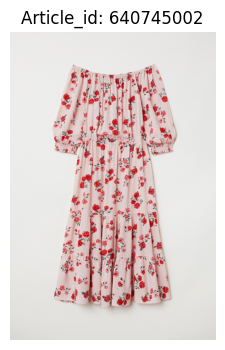

Here are the articles similar to the given article:


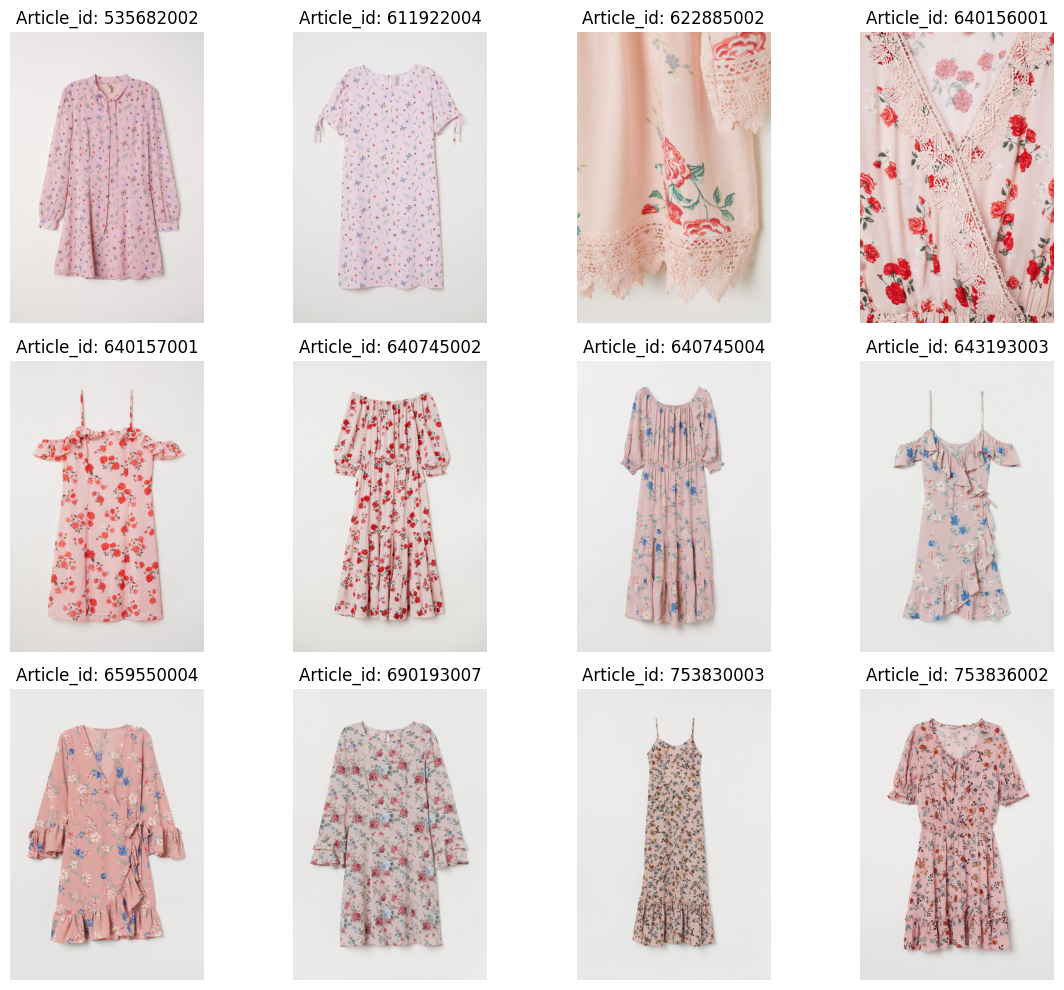

In [85]:
img_dir = '/kaggle/input/h-and-m-personalized-fashion-recommendations/images'

display_similar_articles(article_id, similar_articles, img_dir)

# Observations:
<p>Until now, we successfully implemented a product recommendation system by leveraging cosine similarity on article features. Through this approach, we were able to find and display similar products based on a given article_id, which allows us to provide personalized recommendations for customers.

Key steps involved included:

<ol>
    <li><strong>Feature Extraction:</strong> We first processed and normalized the article features to ensure effective comparison between products.</li>
    <li><strong>Cosine Similarity Calculation:</strong> Using cosine similarity, we quantified the similarity between articles, enabling us to identify products closely related to the chosen article.</li>
    <li><strong>Image Display for Recommendations:</strong> We visually presented the main article alongside similar articles, making it easier to verify the relevance of recommendations.</li>
</ol>
This recommendation system can be used to enhance the shopping experience, as it enables tailored product suggestions based on specific items a customer shows interest in. Whether applied to highlight similar styles, colors, or product types, this approach can provide valuable insights and foster a more engaging, customer-centric shopping journey. 

Now we will suggest relevant items that a customer might purchase based on already purchased item relavance. We will use transactions data to achieve this.<p>

## Next Steps:
* **Co-Purchase Matrix**: Build a matrix of items frequently bought together.
* **Integration & Recommendation:** Combine recommendations based on similarity and co-purchases.Retrieve a comprehensive list of recommendations.
* **Display Function:** Visually present the recommended items with their images.

### Creating a Co-Purchase Matrix:

From EDA we know, Date range for transactions data is from 2018-09-20 00:00:00 to  2020-09-22 00:00:00 with a total duration of 734 . Now we want to consier only last 6 months transactions to recommend relavent items as we dont have enough memory to process complete transactions data and compute co-purchase matrix.

In [21]:
# Convert 't_dat' to datetime
transactions_train_df['t_dat'] = pd.to_datetime(transactions_train_df['t_dat'])
# Define the cutoff date for 3 months prior to September 22, 2020
cutoff_date = pd.to_datetime('2020-06-22')
# Filter transactions for the last 3 months before September 22, 2020
filtered_transactions_df = transactions_train_df[transactions_train_df['t_dat'] >= cutoff_date]

In [22]:
filtered_transactions_df.shape, transactions_train_df.shape

((4056792, 5), (31788324, 5))

In [24]:
#To avoid memory issues we consider only customer_id and article_id. Also change article_id type as object
# Keep only the relevant columns
filtered_transactions = filtered_transactions_df[['customer_id', 'article_id']]

In [25]:
# Create a co-purchase DataFrame
def create_co_purchase_matrix(transactions_df):
    co_purchase_pairs = []

    for customer_id, group in transactions_df.groupby('customer_id'):
        articles = group['article_id'].tolist()
        for article1, article2 in combinations(articles, 2):
            if article1 != article2:
                co_purchase_pairs.append({'article_id1': article1, 'article_id2': article2})

    # Create a DataFrame from the list of co-purchase pairs
    co_purchase = pd.DataFrame(co_purchase_pairs)
    # Count co-purchases
    co_purchase_counts = co_purchase.groupby(['article_id1', 'article_id2']).size().reset_index(name='count')
    
    return co_purchase_counts

In [26]:
co_purchase_matrix = create_co_purchase_matrix(filtered_transactions)
co_purchase_matrix

,article_id1,article_id2,count
0,108775015,179950001,1
1,108775015,316441005,1
2,108775015,372860002,1
3,108775015,574399003,1
4,108775015,575347011,1
...,...,...,...
19192769,956217002,935694002,1
19192770,956217002,935753001,2
19192771,956217002,935787001,1
19192772,956217002,936012003,1


### Integration & Recommendation:

In [109]:
# Create a function to get recommendations
def recommend_products(article_id, co_purchase_matrix, similarity_matrix, num_co_purchase=4, num_similarity=8):
    # Get co-purchased articles
    relevant_co_purchase = co_purchase_matrix[co_purchase_matrix['article_id1'] == article_id]
    relevant_articles = relevant_co_purchase.nlargest(num_co_purchase, 'count')['article_id2'].tolist()
    if len(relevant_articles)>0:
        print(f"People who bought {article_id} also bought {relevant_articles}")
        
    # Get similar articles based on cosine similarity
    similar_articles_indices = similarity_matrix[article_id].nlargest(num_similarity+2).iloc[1:].index.tolist()
    
    similar_articles_indices= [sim_id for sim_id in similar_articles_indices if sim_id != article_id] 
    print(f"Some recommendations similar to {article_id} are {similar_articles_indices}")
  
    # Combine the recommendations
    recommended_articles = list(similar_articles_indices + relevant_articles)

    # Limit to 12 recommended items
    return recommended_articles[:12]

In [110]:
article_id = 712801005
#random.choice(similarity_df.index)
#549437014 
recommended_products = recommend_products(article_id, co_purchase_matrix, similarity_df)
print("Recommended Products:", recommended_products)

People who bought 712801005 also bought [706016002, 706016020, 710058001, 809961002]
Some recommendations similar to 712801005 are [616871001, 622825001, 676503001, 708359025, 718262005, 766450006, 814594006, 866939003]
Recommended Products: [616871001, 622825001, 676503001, 708359025, 718262005, 766450006, 814594006, 866939003, 706016002, 706016020, 710058001, 809961002]


### Display Function to display recommended images

In [104]:
# Helper function to display a set of article images
def display_article_images(articles, img_dir, title_text, start_idx=1, rows=3, cols=4):
    plt.figure(figsize=(10, 8))
    for idx, article_id in enumerate(articles, start=start_idx):
        subfolder = '0' + str(article_id)[:2]
        img_path = os.path.join(img_dir, subfolder, f'0{article_id}.jpg')

        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(rows, cols, idx)
            plt.imshow(img)
            plt.title(f'Article_id: {article_id}')
            plt.axis('off')
        else:
            print(f"Image for Article_id {article_id} not found.")
    plt.tight_layout()
    plt.show()

# Main function to display main article image and its similar articles
def display_similar_articles(article_id, similar_articles, img_dir):
    # Display main article image
    main_subfolder = '0' + str(article_id)[:2]
    main_img_path = os.path.join(img_dir, main_subfolder, f'0{article_id}.jpg')
    
    print(f"We are looking for recommendations (similarity) of the '0{article_id}.jpg':")
    if os.path.exists(main_img_path):
        plt.figure(figsize=(3, 4))
        img = Image.open(main_img_path)
        plt.imshow(img)
        plt.title(f'Article_id: {article_id}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for Article_id {article_id} not found.")

    # Display images for similar articles
    print("Here are the articles similar to the given article:")
    display_article_images(similar_articles[:8], img_dir, "Similar Articles")

    # Display images for articles bought by similar customers
    print("Users who bought your product also bought:")
    display_article_images(similar_articles[8:], img_dir, "Relevant Articles")


We are looking for recommendations (similarity) of the '0712801005.jpg':


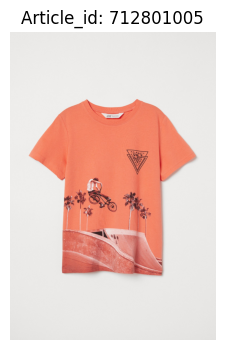

Here are the articles similar to the given article:


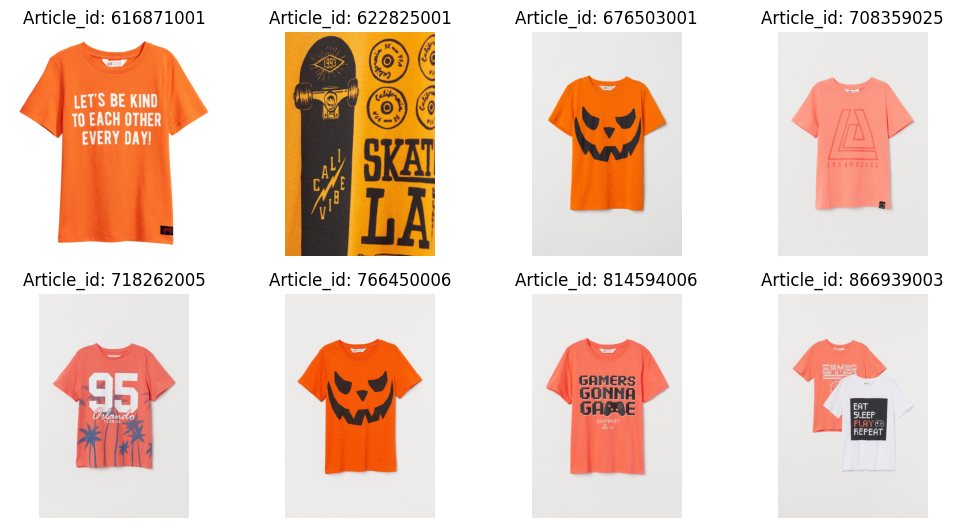

Users who bought your product also bought:


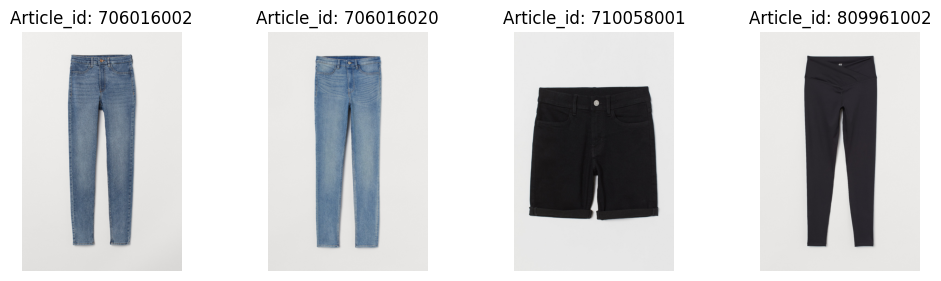

In [111]:
display_similar_articles(article_id, recommended_products, img_dir)

# Conclusion:

<p>Building on our initial recommendation system using cosine similarity, we’ve enhanced our approach by incorporating transaction data to suggest items commonly purchased together. This expanded system provides not only similar products but also relevant co-purchases, creating a more comprehensive recommendation experience.

**Process Overview:**

**Cosine Similarity Calculation:** Using cosine similarity, we quantified the similarity between articles, enabling us to identify products closely related to the chosen article.

**Co-purchase Analysis:** Using transaction data, we identified items frequently bought together, which adds a practical relevance layer beyond similarity alone.

**Combined Recommendations:** We now suggest a blend of 12 items—8 based on cosine similarity and 4 from co-purchase patterns—ensuring that customers receive well-rounded suggestions reflective of both item features and actual purchase behavior.

Overall, this notebook showcases a foundational yet effective method for personalized recommendations in retail. By combining content-based and co-purchase recommendations, we offer a more personalized shopping experience, aligning suggestions with both product similarities and popular customer pairings. This approach supports cross-selling while making the recommendation system more engaging and useful for the customer.<p/>